In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
from pathlib import Path
import os

data_dir = Path('./data/')
data_path = Path('./data/fashion_mnist.npz')

if data_path.is_file():
    print('Data found. Loading...')
    data = np.load(data_path)
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
else:
    print('Data not found. Downloading...')
    if not data_dir.is_dir():
        os.mkdir(data_dir)
    from keras.datasets import fashion_mnist
    (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train/255., X_test/255.
    np.savez_compressed(data_path, X_train, Y_train, X_test, Y_test)

Data found. Loading...


In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
CLASS_LABELS = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

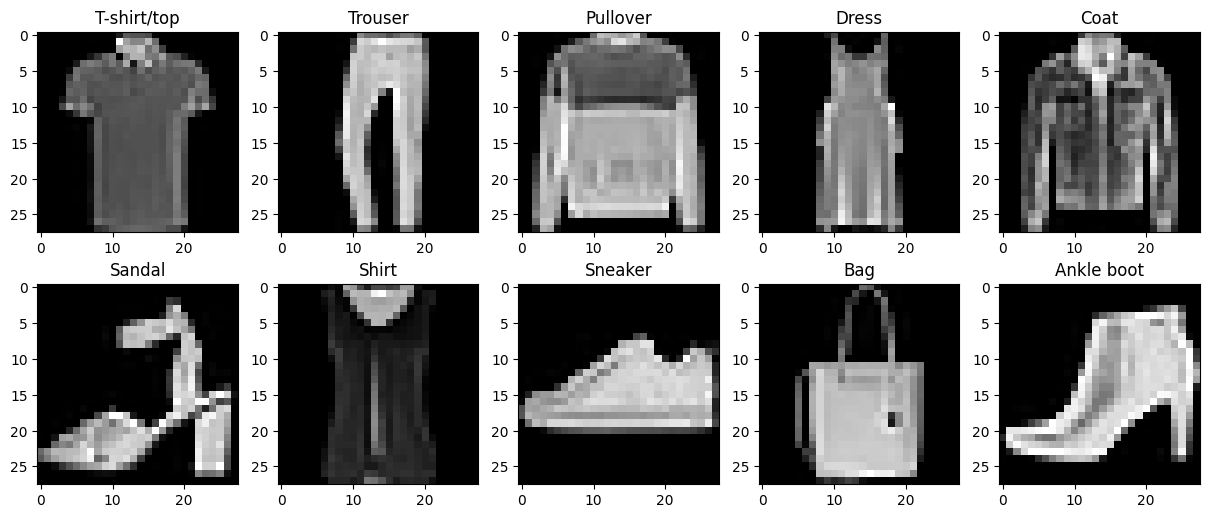

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row_no = i//5
    col_no = i%5
    X_sub = X_train[Y_train==i]
    index = np.random.choice(a=range(len(X_sub)), size=1)
    ax[row_no][col_no].imshow(X_sub[index].reshape((28, 28)), cmap='gray')
    ax[row_no][col_no].set_title(CLASS_LABELS[i])

## Activations

In [6]:
class Identity():
    """
    Implements the identity function, f(x) = x
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns identity(x) for input x

        Arg: x (np.array): The input
        Returns: identity(x) (np.array): The output, identity(x) (= x) 
        """
        return x
    
    def backward(self, output: np.array) -> np.array:
        """
        Returns gradient of identity output wrt inputs, given the output

        Arg: output (np.array): The output produced by the identity activation, corresponding to the input for which gradient
            is being computed.
        
        Returns:
            grad (np.array): The gradient of the identity activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return np.ones_like(output)

In [7]:
class Sigmoid():
    """
    Implements the sigmoid logistic function, f(x) = 1/(1 + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns sigmoid(x) for input x

        Arg: x (np.array): The input
        Returns: sigmoid(x) (np.array): The output, sigmoid(x)
        """
        return 1 / (1 + np.exp(-x))
    
    def backward(self, output: np.array) -> np.array:
        """
        Returns gradient of sigmoid outputs wrt inputs, given the output

        Arg: output (np.array): The output produced by the sigmoid activation, corresponding to the input for which gradient
            is being computed.
        
        Returns:
            grad (np.array): The gradient of the sigmoid activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return output * (1 - output)

In [8]:
class ReLU():
    """
    Implements the rectified linear unit (ReLU) function, f(x) = max(0, x) 
    """
    def __init__(self) -> None:
        pass
        
    def forward(self, x: np.array) -> np.array:
        """
        Returns relu(x) for input x

        Arg: x (np.array): The input
        Returns: relu(x) (np.array): The output, relu(x)
        """
        return np.maximum(0., x)
    
    def backward(self, output: np.array) -> np.array:
        """
        Returns gradient of relu outputs wrt inputs, given the output

        Arg: output (np.array): The output produced by the relu activation, corresponding to the input for which gradient
            is being computed.
        
        Returns:
            grad (np.array): The gradient of the relu activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return np.sign(output, dtype=np.float64)

In [9]:
class Tanh():
    """
    Implements the hyperbolic tan (tanh) function, f(x) = (exp(x) - exp(-x))/(exp(x) + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns tanh(x) for input x

        Arg: x (np.array): The input
        Returns: tanh(x) (np.array): The output, tanh(x)
        """
        # tanh(x) = (exp(2x) - 1)/(exp(2x) + 1) = 2 / (1 + exp(-2x)) - 1
        return 2 / (1 + np.exp(-2*x)) - 1
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of tanh outputs wrt inputs, given the output

        Arg: output (np.array): The output produced by the tanh activation, corresponding to the input for which gradient
            is being computed.
        
        Returns:
            grad (np.array): The gradient of the tanh activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        # d(tanh(x))/dx = 4exp(2x)/(1 + exp(2x))**2
        # exp(2x)/(1 + exp(2x)) = (tanh(x) + 1)/2, 1/(1 + exp(2x)) = (1 - tanh(x))/2
        # d(tanh(x))/dx = 1 - tanh(x)**2
        return 1 - output**2

In [10]:
class Softmax():
    """
    Implements the softmax function, f(x) = exp(x) / sum(exp(x))

    Arg: eps (float, optional): The minimum probability/output to produce. Provides stability in loss/gradient calculation.
        Defaults to 1e-8.
    """
    def __init__(self, eps: float=1e-8) -> None:
        self.eps = eps

    def forward(self, x: np.array) -> np.array:
        """
        Returns softmax(x) for input x

        Arg: x (np.array): The input
        Returns: softmax(x) (np.array): The output, softmax(x)
        """
        max_x = np.max(x, axis=-1).reshape(-1, 1)
        exp_x = np.exp(x - max_x)
        total = np.sum(exp_x, axis=-1).reshape(-1, 1)
        return np.maximum((exp_x / total).reshape(x.shape), self.eps)
    
    def backward(self, output: np.array) -> np.array: 
        """
        Returns gradient of softmax outputs wrt inputs, given the output and true class

        Arg: output (np.array): The output produced by the softmax activation, corresponding to the input for which gradient
            is being computed.
        
        Returns:
            grad (np.array): The gradient of the softmax activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        if len(output.shape) == 1:
            return output * np.eye(len(output)) - np.matmul(output.reshape(-1, 1), output.reshape(1, -1))
        else:
            return np.array([op * np.eye(len(op)) - np.matmul(op.reshape(-1, 1), op.reshape(1, -1)) for op in output])
        

## Loss functions

In [11]:
class CrossEntropyLoss():
    """
    Implements the cross entropy loss, L(y_hat, y) = -log(y_hat[y]) [where y is the true class label, from 0 to num_classes-1]
    """
    def __init__(self) -> None:
        pass

    def forward(self, y_pred: np.array, y_true) -> np.float64:
        """
        Returns the loss for predicted probabilities y_pred, with true class label y_true

        Args:
            y_pred (np.array): The predicted probabilities of each of the classes. 
                Array of shape (num_classes,) or (num_samples, num_classes).
            y_true: The true class label(s) of the data point(s). Could be a scalar or an array of shape (num_samples,).

        Returns:
            The (average) cross entropy loss (across all samples), a np.float64 object.
        """
        if len(y_pred.shape) == 1:
            return -np.log(y_pred[y_true])
        else:
            return np.mean(np.array([
                -np.log(y_pred[i][y]) for i,y in enumerate(y_true)
            ]))
    
    def backward(self, y_pred: np.array, y_true) -> np.array:
        """
        Returns the derivative of the loss wrt the predicted probability of the true class y_true

        Args:
            y_pred (np.array): The predicted probabilities of each of the classes. 
                Array of shape (num_classes,) or (num_samples, num_classes).
            y_true: The true class label(s) of the data point(s). Could be a scalar or an array of shape (num_samples,).

        Returns:
            grad (np.array): The gradient of the loss wrt the inputs (probabilties) given to the loss function.
                Array of shape matching y_pred.
        """
        grad = np.zeros_like(y_pred)
        if len(y_pred.shape) == 1:
            grad[y_true] = -1 / y_pred[y_true]
        else:
            for i,y in enumerate(y_true):
                grad[i][y] = -1 / y_pred[i][y]
        return grad




In [12]:
class MeanSquaredErrorLoss():
    """
    Implements the mean squared error loss, L(y_hat, y) = 0.5 * sum((y_hat - y)**2)
    """
    def __init__(self) -> None:
        pass

    def forward(self, y_pred: np.array, y_true) -> np.float64:
        """
        Returns the loss for predictions y_pred and true labels y_true.

        Args:
            y_pred (np.array): The predicted labels, array of shape (num_outputs,) or (num_samples, num_outputs).
            y_true (np.array or scalar): The true class labels, scalar or array of shape (num_samples,).

        Returns:
            The mean squared error across all samples, a np.float64 object.
        """
        y_true_proba = np.zeros_like(y_pred)
        if len(y_pred.shape) == 1:
            y_true_proba[y_true] == 1.
            count = 1
        else:
            for i,y in enumerate(y_true):
                y_true_proba[i][y] = 1.
            count = len(y_true)
        return 0.5 * np.sum((y_pred - y_true_proba)**2) / count

    def backward(self, y_pred: np.array, y_true) -> np.array:
        """
        Returns the derivative of the loss wrt the predicted probability of the true class y_true

        Args:
            y_pred (np.array): The predicted probabilities of each of the classes. 
                Array of shape (num_classes,) or (num_samples, num_classes).
            y_true: The true class label(s) of the data point(s). Could be a scalar or an array of shape (num_samples,).

        Returns:
            grad (np.array): The gradient of the loss wrt the inputs (probabilties) given to the loss function.
                Array of shape matching y_pred.
        """
        y_true_proba = np.zeros_like(y_pred)
        if len(y_pred.shape) == 1:
            y_true_proba[y_true] == 1.
        else:
            for i,y in enumerate(y_true):
                y_true_proba[i][y] = 1.
        return y_pred - y_true_proba

## Metrics

In [13]:
def categorical_accuracy(Y_true, Y_pred) -> float:
    if len(Y_pred.shape) == 1:
        return 1. if np.argmax(Y_pred) == Y_true else 0.
    else:
        Y_pred_class = np.argmax(Y_pred, axis=1)
        return np.sum(Y_pred_class == Y_true) / len(Y_true)

## Feedforward neural network

In [14]:
class Layer():
    """
    Models a single layer of a feedforward neural network. 

    Args:
        input_size (int): number of inputs to the layer
        output_size (int): number of outputs produced by the layer
        activation (str, optional): activation function used by the layer. 
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        if weight_init == 'xavier':
            self.w = np.random.normal(scale=np.sqrt(2/(input_size + output_size)), size=(output_size, input_size))
            self.b = np.random.normal(scale=np.sqrt(2/(input_size + output_size)), size=(output_size,))
        else:
            self.w = np.random.normal(size=(output_size, input_size))   # shape: (output_size, input_size)
            self.b = np.random.normal(size=(output_size,))  # shape: (output_size,)
        self.grad_w = np.zeros_like(self.w)
        self.grad_b = np.zeros_like(self.b)
        if activation == 'identity' or activation.__class__ == Identity:
            self.activation = Identity()
        elif activation == 'sigmoid' or activation.__class__ == Sigmoid:
            self.activation = Sigmoid()
        elif activation == 'tanh' or activation.__class__ == Tanh:
            self.activation = Tanh()
        elif activation == 'relu' or activation.__class__ == ReLU:
            self.activation = ReLU()
        elif activation == 'softmax' or activation.__class__ == Softmax:
            self.activation = Softmax()
    
    def forward(self, x: np.array, eval_mode: bool = False) -> np.array:
        """
        Computes the output of the layer for given input.

        Args: 
            x (np.array): the input vector for the layer, of size (input_size,) or (num_samples, input_size).
            eval_mode (bool, optional): whether to compute in eval mode, without storing input, pre-activation and output.
                Defaults to False.
        Returns: h (np.array): the output produced by the layer, of size (output_size,) or (num_samples, output_size).
        """
        if not eval_mode:
            self.input = x
            self.pre_activation = np.matmul(x, self.w.T) + self.b
            self.output = self.activation.forward(self.pre_activation)
            return self.output
        else:
            return self.activation.forward(np.matmul(x, self.w.T) + self.b)
    
    def backward(self, accumulated_grads: np.array, w_next: np.array = None) -> np.array:
        """
        Computes the relevant necessary gradients of the layer, given the gradient accumulated until the succeeding layer.

        Args:
            accumulated_grads (np.array): gradient accumulated from the loss until the following layer, i.e. grad(L) wrt a_(i+1)
                Array of shape (num_features,) or (num_samples, num_features).
            w_next (np.array, optional): weight associated with the succeeding layer. Not applicable for the output layer.
                Defaults to None.
        
        Returns: grad_to_return (np.array), gradient accumulated until the current layer, i.e., grad(L) wrt a_i
        """
        # accumulated_grads ~ grad(L) wrt a_i+1
        activation_grad = self.activation.backward(self.output)
        if w_next is not None:
            grad_to_return = np.matmul(accumulated_grads, w_next) * activation_grad
        else:
            if len(self.output.shape) == 1:
                grad_to_return = np.matmul(accumulated_grads.reshape(1, -1), activation_grad)
            else:
                grad_to_return = np.array([np.matmul(accumulated_grads[i].reshape(1, -1), activation_grad[i]).reshape(-1) for i in range(len(accumulated_grads))])
        # grad_to_return ~ grad(L) wrt a_i
        self.grad_w += np.matmul(grad_to_return.T.reshape(self.w.shape[0], -1), self.input.reshape(-1, self.w.shape[1])) / self.input.reshape(-1, self.w.shape[1]).shape[0]
        if len(self.input.shape) == 1:
            self.grad_b += grad_to_return
        else:
            self.grad_b += np.mean(grad_to_return, axis=0)
        return grad_to_return

In [15]:
class FeedForwardNeuralNetwork():
    """
    Models a vanilla feedforward neural network, with softmax activation for the outputs.

    Args:
        num_layers (int): number of hidden layers in the network
        hidden_size (int): number of neurons per hidden layer
        input_size (int): size/dimension of inputs given to the network. 
            Defaults to 784, flattened size of mnist/fashion-mnist data.
        output_size (int): number of outputs produced by the network.
            Defaults to 10, number of classes of mnist/fashion-mnist data.
        activation (str, optional): activation function for the hidden layers.
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        num_layers: int,
        hidden_size: int,
        input_size: int = 784,
        output_size: int = 10,
        activation = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        self.input_layer = Layer(input_size, hidden_size, activation, weight_init)
        self.hidden_layers = []
        for i in range(num_layers):
            self.hidden_layers.append(Layer(hidden_size, hidden_size, activation, weight_init))
        self.output_layer = Layer(hidden_size, output_size, 'softmax', weight_init)
    
    def forward(self, x: np.array, eval_mode: bool = False) -> np.array:
        """
        Computes the output of the network for given input.

        Args: 
            x (numpy.array): the input to the network, of size (input_size,) or (num_samples, input_size)
            eval_mode (bool, optional): whether to compute in eval mode, without storing input, pre-activation and output
            in each layer. Defaults to False.
        Returns: y_hat (numpy.array): the output produced by the network, of size (output_size,) or (num_samples, output_size)
        """
        result = self.input_layer.forward(x, eval_mode)
        for hidden_layer in self.hidden_layers:
            result = hidden_layer.forward(result, eval_mode)
        return self.output_layer.forward(result, eval_mode)
    
    def backward(self, accumulated_grads: np.array, y_true) -> None:
        """
        Computes the gradient of the loss wrt all the parameters (weights, biases) of the network, given the gradient of the loss
        wrt the output of the network.

        Args:
            accumulated_grads (np.array): gradient of the loss wrt the outputs of the network
                Array of size (num_classes,) or (num_samples, num_classes).
            y_true: the true class label(s) for the data input(s) to the network
        """
        self.y_true = y_true
        accumulated_grads = self.output_layer.backward(accumulated_grads)
        w_next = self.output_layer.w
        for hidden_layer in reversed(self.hidden_layers):
            accumulated_grads = hidden_layer.backward(accumulated_grads, w_next=w_next)
            w_next = hidden_layer.w
        self.input_layer.backward(accumulated_grads, w_next=w_next)
    
    def zero_grad(self) -> None:
        """
        Sets the gradients of all the parameters of the network to zero.
        """
        self.output_layer.grad_w, self.output_layer.grad_b = 0., 0.
        for hidden_layer in self.hidden_layers:
            hidden_layer.grad_w, hidden_layer.grad_b = 0., 0.
        self.input_layer.grad_w, self.input_layer.grad_b = 0., 0.
        

## Optimizers

In [16]:
class StochasticGradientDescent():
    """
    Class to implement stochastic (mini-batch vanilla) gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.model.output_layer.w -= self.lr * (self.model.output_layer.grad_w + self.weight_decay * self.model.output_layer.w)
        self.model.output_layer.b -= self.lr * (self.model.output_layer.grad_b + self.weight_decay * self.model.output_layer.b)
        for hidden_layer in self.model.hidden_layers:
            hidden_layer.w -= self.lr * (hidden_layer.grad_w + self.weight_decay * hidden_layer.w)
            hidden_layer.b -= self.lr * (hidden_layer.grad_b + self.weight_decay * hidden_layer.b)
        self.model.input_layer.w -= self.lr * (self.model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w)
        self.model.input_layer.b -= self.lr * (self.model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b)


In [17]:
class MomentumGradientDescent():
    """
    Class to implement momentum-based gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        beta (float, optional): The momentum to be used, quantifying the confidence in the history of updates.
            Should range from 0 to 1. Defaults to 0.9.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        beta: float = 0.9,
        weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.beta = beta
        self.lr = lr
        self.weight_decay = weight_decay
        self.input_u_w = np.zeros_like(model.input_layer.w)
        self.input_u_b = np.zeros_like(model.input_layer.b)
        self.hidden_u_ws = []
        self.hidden_u_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_u_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_u_bs.append(np.zeros_like(hidden_layer.b))
        self.output_u_w = np.zeros_like(model.output_layer.w)
        self.output_u_b = np.zeros_like(model.output_layer.b)

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.output_u_w = self.beta * self.output_u_w + self.lr * (self.model.output_layer.grad_w + self.weight_decay * self.model.output_layer.w)
        self.model.output_layer.w -= self.output_u_w
        self.output_u_b = self.beta * self.output_u_b + self.lr * (self.model.output_layer.grad_b + self.weight_decay * self.model.output_layer.b)
        self.model.output_layer.b -= self.output_u_b
        for hidden_layer, hidden_u_w, hidden_u_b in zip(self.model.hidden_layers, self.hidden_u_ws, self.hidden_u_bs):
            hidden_u_w = self.beta * hidden_u_w + self.lr * (hidden_layer.grad_w + self.weight_decay * hidden_layer.w)
            hidden_layer.w -= hidden_u_w
            hidden_u_b = self.beta * hidden_u_b + self.lr * (hidden_layer.grad_b + self.weight_decay * hidden_layer.b)
            hidden_layer.b -= hidden_u_b
        self.input_u_w = self.beta * self.input_u_w + self.lr * (self.model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w)
        self.model.input_layer.w -= self.input_u_w
        self.input_u_b = self.beta * self.input_u_b + self.lr * (self.model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b)
        self.model.input_layer.b -= self.input_u_b

In [18]:
class NesterovGradientDescent():
    """
    Class to implement Nesterov accelerated gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        beta (float, optional): The momentum to be used, quantifying the confidence in the history of updates (and the lookahead).
            Should range from 0 to 1. Defaults to 0.9.
        loss_fn (Any, optional): The loss function used in training the model, used to calculate the lookahead gradient.
            Defaults to CrossEntropyLoss().
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        beta: float = 0.9,
        loss_fn = CrossEntropyLoss(),
        weight_decay : float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.beta = beta
        self.loss_fn = loss_fn
        self.weight_decay = weight_decay
        self.input_u_w = np.zeros_like(model.input_layer.w)
        self.input_u_b = np.zeros_like(model.input_layer.b)
        self.hidden_u_ws = []
        self.hidden_u_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_u_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_u_bs.append(np.zeros_like(hidden_layer.b))
        self.output_u_w = np.zeros_like(model.output_layer.w)
        self.output_u_b = np.zeros_like(model.output_layer.b)
    
    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        projected_model = FeedForwardNeuralNetwork(
            num_layers=len(self.model.hidden_layers),
            hidden_size=self.model.input_layer.b.shape[0],
            input_size=self.model.input_layer.w.shape[1],
            output_size=self.model.output_layer.b.shape[0],
            activation=self.model.input_layer.activation
        )
        projected_model.input_layer.w = self.model.input_layer.w - self.beta * self.input_u_w
        projected_model.input_layer.b = self.model.input_layer.b - self.beta * self.input_u_b
        for projected_hidden_layer, curr_hidden_layer, hidden_u_w, hidden_u_b in zip(projected_model.hidden_layers, self.model.hidden_layers, self.hidden_u_ws, self.hidden_u_bs):
            projected_hidden_layer.w = curr_hidden_layer.w - self.beta * hidden_u_w
            projected_hidden_layer.b = curr_hidden_layer.b - self.beta * hidden_u_b
        projected_model.output_layer.w = self.model.output_layer.w - self.beta * self.output_u_w
        projected_model.output_layer.b = self.model.output_layer.b - self.beta * self.output_u_b
        # Model with lookahead parameters

        y_pred = projected_model.forward(self.model.input_layer.input)
        accumulated_grads = self.loss_fn.backward(y_pred, self.model.y_true)
        projected_model.backward(accumulated_grads, self.model.y_true)
        # Lookahead gradient computation

        self.input_u_w = self.beta * self.input_u_w + self.lr * (projected_model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w)
        self.model.input_layer.w -= self.input_u_w
        self.input_u_b = self.beta * self.input_u_b + self.lr * (projected_model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b)
        self.model.input_layer.b -= self.input_u_b
        for hidden_layer, projected_hidden_layer, hidden_u_w, hidden_u_b in zip(self.model.hidden_layers, projected_model.hidden_layers, self.hidden_u_ws, self.hidden_u_bs):
            hidden_u_w = self.beta * hidden_u_w + self.lr * (projected_hidden_layer.grad_w + self.weight_decay * hidden_layer.w)
            hidden_layer.w -= hidden_u_w
            hidden_u_b = self.beta * hidden_u_b + self.lr * (projected_hidden_layer.grad_b + self.weight_decay * hidden_layer.b)
            hidden_layer.b -= hidden_u_b
        self.output_u_w = self.beta * self.output_u_w + self.lr * (projected_model.output_layer.grad_w + self.weight_decay * (self.model.output_layer.w))
        self.model.output_layer.w -= self.output_u_w
        self.output_u_b = self.beta * self.output_u_b + self.lr * (projected_model.output_layer.grad_b + self.weight_decay * (self.model.output_layer.b))
        self.model.output_layer.b -= self.output_u_b
        # Parameter updates

In [19]:
class RMSProp():
    """
    Class to implement RMSProp optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        beta (float, optional): The momentum to be used, quantifying the confidence in the history of updates.
            Should range from 0 to 1. Defaults to 0.9.
        eps(float, optional): The amount to be added to the accumulated history, to add stability to computation.
            Defaults to 1e-8.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
            self,
            model: FeedForwardNeuralNetwork,
            lr: float = 1e-3,
            beta: float = 0.9,
            eps: float = 1e-8,
            weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.weight_decay = weight_decay
        self.input_v_w = np.zeros_like(model.input_layer.w)
        self.input_v_b = np.zeros_like(model.input_layer.b)
        self.hidden_v_ws = []
        self.hidden_v_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_v_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_v_bs.append(np.zeros_like(hidden_layer.b))
        self.output_v_w = np.zeros_like(model.output_layer.w)
        self.output_v_b = np.zeros_like(model.output_layer.b)

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.input_v_w = self.beta * self.input_v_w + (1 - self.beta) * self.model.input_layer.grad_w**2
        self.model.input_layer.w -= self.lr * (self.model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w) / np.sqrt(self.input_v_w + self.eps)
        self.input_v_b = self.beta * self.input_v_b + (1 - self.beta) * self.model.input_layer.grad_b**2 
        self.model.input_layer.b -= self.lr * (self.model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b) / np.sqrt(self.input_v_b + self.eps)
        for hidden_layer, hidden_v_w, hidden_v_b in zip(self.model.hidden_layers, self.hidden_v_ws, self.hidden_v_bs):
            hidden_v_w = self.beta * hidden_v_w + (1 - self.beta) * hidden_layer.grad_w**2
            hidden_layer.w -= self.lr * (hidden_layer.grad_w + self.weight_decay * hidden_layer.w) / np.sqrt(hidden_v_w + self.eps)
            hidden_v_b = self.beta * hidden_v_b + (1 - self.beta) * hidden_layer.grad_b**2
            hidden_layer.b -= self.lr * (hidden_layer.grad_b + self.weight_decay * hidden_layer.b) / np.sqrt(hidden_v_b + self.eps)
        self.output_v_w = self.beta * self.output_v_w + (1 - self.beta) * self.model.output_layer.grad_w**2
        self.model.output_layer.w -= self.lr * (self.model.output_layer.grad_w + self.weight_decay * self.model.output_layer.w) / np.sqrt(self.output_v_w + self.eps)
        self.output_v_b = self.beta * self.output_v_b + (1 - self.beta) * self.model.output_layer.grad_b**2 
        self.model.output_layer.b -= self.lr * (self.model.output_layer.grad_b + self.weight_decay * self.model.output_layer.b) / np.sqrt(self.output_v_b + self.eps)


In [28]:
from typing import Tuple

class Adam():
    """
    Class to implement Adam optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        betas (tuple[float, float], optional): The betas to be used to store the history, as in momentum and in 
            RMSProp. betas[0] corresponds to momentum, betas[1] corresponds to beta of RMSProp.
            Both values to range from 0 to 1. Defaults to (0.9, 0.999).
        eps(float, optional): The amount to be added to the accumulated history, to add stability to computation.
            Defaults to 1e-8.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
            self,
            model: FeedForwardNeuralNetwork,
            lr: float = 1e-3,
            betas: Tuple[float, float] = (0.9, 0.999),
            eps: float = 1e-8,
            weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.pow_beta1, self.pow_beta2 = betas
        self.input_m_w, self.input_v_w = np.zeros_like(self.model.input_layer.w), np.zeros_like(self.model.input_layer.w)
        self.input_m_b, self.input_v_b = np.zeros_like(self.model.input_layer.b), np.zeros_like(self.model.input_layer.b)
        for hidden_layer in self.model.hidden_layers:
            self.hidden_m_w, self.hidden_v_w = np.zeros_like(hidden_layer.w), np.zeros_like(hidden_layer.w)
            self.hidden_m_b, self.hidden_v_b = np.zeros_like(hidden_layer.b), np.zeros_like(hidden_layer.b)
        self.output_m_w, self.output_v_w = np.zeros_like(self.model.output_layer.w), np.zeros_like(self.model.output_layer.w)
        self.output_m_b, self.output_v_b = np.zeros_like(self.model.output_layer.b), np.zeros_like(self.model.output_layer.b)

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.input_m_w = self.beta1 * self.input_m_w + (1 - self.beta1) * self.model.input_layer.grad_w
        self.input_v_w = self.beta1 * self.input_v_w + (1 - self.beta1) * self.model.input_layer.grad_w**2
        self.model.input_layer.w -= self.lr * ((self.input_m_w / (1 - self.pow_beta1)) / (self.eps + np.sqrt(self.input_v_w / (1 - self.pow_beta2))) + self.weight_decay * self.model.input_layer.w)
        self.input_m_b = self.beta1 * self.input_m_b + (1 - self.beta1) * self.model.input_layer.grad_b
        self.input_v_b = self.beta1 * self.input_v_b + (1 - self.beta1) * self.model.input_layer.grad_b**2
        self.model.input_layer.b -= self.lr * ((self.input_m_b / (1 - self.pow_beta1)) / (self.eps + np.sqrt(self.input_v_b / (1 - self.pow_beta2))) + self.weight_decay * self.model.input_layer.b)
        for hidden_layer in self.model.hidden_layers:
            self.hidden_m_w = self.beta1 * self.hidden_m_w + (1 - self.beta1) * hidden_layer.grad_w
            self.hidden_v_w = self.beta1 * self.hidden_v_w + (1 - self.beta1) * hidden_layer.grad_w**2
            hidden_layer.w -= self.lr * ((self.hidden_m_w / (1 - self.pow_beta1)) / (self.eps + np.sqrt(self.hidden_v_w / (1 - self.pow_beta2))) + self.weight_decay * hidden_layer.w)
            self.hidden_m_b = self.beta1 * self.hidden_m_b + (1 - self.beta1) * hidden_layer.grad_b
            self.hidden_v_b = self.beta1 * self.hidden_v_b + (1 - self.beta1) * hidden_layer.grad_b**2
            hidden_layer.b -= self.lr * ((self.hidden_m_b / (1 - self.pow_beta1)) / (self.eps + np.sqrt(self.hidden_v_b / (1 - self.pow_beta2))) + self.weight_decay * hidden_layer.b)
        self.output_m_w = self.beta1 * self.output_m_w + (1 - self.beta1) * self.model.output_layer.grad_w
        self.output_v_w = self.beta1 * self.output_v_w + (1 - self.beta1) * self.model.output_layer.grad_w**2
        self.model.output_layer.w -= self.lr * ((self.output_m_w / (1 - self.pow_beta1)) / (self.eps + np.sqrt(self.output_v_w / (1 - self.pow_beta2))) + self.weight_decay * self.model.output_layer.w)
        self.output_m_b = self.beta1 * self.output_m_b + (1 - self.beta1) * self.model.output_layer.grad_b
        self.output_v_b = self.beta1 * self.output_v_b + (1 - self.beta1) * self.model.output_layer.grad_b**2
        self.model.output_layer.b -= self.lr * ((self.output_m_b / (1 - self.pow_beta1)) / (self.eps + np.sqrt(self.output_v_b / (1 - self.pow_beta2))) + self.weight_decay * self.model.output_layer.b)
        self.pow_beta1 *= self.beta1
        self.pow_beta2 *= self.beta2



In [ ]:
class NAdam():
    """
    Class to implement NAdam optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        betas (tuple[float, float], optional): The betas to be used to store the history, as in momentum and in 
            RMSProp. betas[0] corresponds to momentum (and lookahead), betas[1] corresponds to beta of RMSProp.
            Both values to range from 0 to 1. Defaults to (0.9, 0.999).
        eps(float, optional): The amount to be added to the accumulated history, to add stability to computation.
            Defaults to 1e-8.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
            self,
            model: FeedForwardNeuralNetwork,
            lr: float = 1e-3,
            betas: Tuple[float, float] = (0.9, 0.999),
            eps: float = 1e-8,
            weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        pass

## Helper functions

In [20]:
from typing import Dict, List

def train(
    model: FeedForwardNeuralNetwork,
    X_train: np.array,
    Y_train,
    X_val: np.array,
    Y_val,
    optimizer,
    loss_fn = CrossEntropyLoss(),
    metric = categorical_accuracy,
    epochs: int = 10,
    batch_size: int = 64
) -> Dict[str, List]:
    """
    Trains the model `model` on training data (X_train, Y_train) for `epochs` epochs using optimization algorithm `optimizer`,
    loss function `loss_fn`, and batch size `batch_size`, computing train and validation loss and score, using provided scoring
    metric `metric`.

    Args:
        model (FeedForwardNeuralNetwork): The model to train.
        X_train (np.array): Training data. Array of shape (num_samples_train, num_inputs) or (num_inputs,).
        Y_train (np.array or scalar): Training label(s). Array of shape (num_samples_train,) or int.
        X_val (np.array): Validation data. Array of shape (num_samples_val, num_inputs) or (num_inputs,).
        Y_val (np.array or scalar): Validation label(s). Array of shape (num_samples_val,) or int.
        optimizer: Optimization algorithm to use.
        loss_fn (optional): The loss function to use. Defaults to CrossEntropyLoss().
        metric (callable, optional): The scoring metric to use. Defaults to categorical_accuracy.
        epochs (int, optional): The number of epochs to train for. Defaults to 10.
        batch_size (int, optional): The batch size to use for training. Defaults to 64.
    
    Returns:
        history (dict[str, list]): A dictionary containing information on time/training evolution of the model.
            Valid keys: epoch, train_loss, train_score, val_loss, val_score.
            Each value is a list containing `epochs` entries, denoting the performance of the model during each
            epoch of training.
    """
    history = {
        'epoch': [],
        'train_loss': [],
        'train_score': [],
        'val_loss': [],
        'val_score': []
    }
    NUM_BATCHES = int(np.ceil(len(X_train)/batch_size))
    for epoch in range(epochs):
        train_loss = 0.0
        train_score = 0.0
        for batch in range(NUM_BATCHES):
            X_train_batch = X_train[batch*batch_size:np.minimum(batch_size*(batch+1), len(X_train))]
            Y_train_batch = Y_train[batch*batch_size:np.minimum(batch_size*(batch+1), len(X_train))]
            model.zero_grad()
            Y_pred_train = model.forward(X_train_batch)
            loss = loss_fn.forward(Y_pred_train, Y_train_batch)
            loss_grad = loss_fn.backward(Y_pred_train, Y_train_batch)
            model.backward(loss_grad, Y_train_batch)
            optimizer.step()
            train_loss += loss / NUM_BATCHES
            train_score += metric(Y_train_batch, Y_pred_train) / NUM_BATCHES
        Y_pred_val = model.forward(X_val, True)
        val_loss = loss_fn.forward(Y_pred_val, Y_val)
        val_score = metric(Y_val, Y_pred_val)
        history['epoch'].append(epoch+1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_score'].append(train_score)
        history['val_score'].append(val_score)
        print(f'[Epoch {epoch+1}/{epochs}] train loss: {train_loss:.6f}, val loss: {val_loss: .6f} || train score: {train_score:.6f}, val score: {val_score:.6f}')
    return history

In [21]:
def predict(
        model: FeedForwardNeuralNetwork,
        X: np.array
) -> np.array:
        """
        Predicts the outputs corresponding to provided data, as produced by the model.

        Args:
                model (FeedForwardNeuralNetwork): The model to predict with.
                X (np.array): The data to predict on. Array of shape (num_samples, num_inputs) or (num_inputs,).
        
        Returns:
                Y (np.array): The predicted probabilities of each class, corresponding to each data point.
                        Array of shape (num_samples, num_outputs) or (num_outputs,).
        """
        return model.forward(X, True)

In [37]:
model = FeedForwardNeuralNetwork(4, 128, activation='relu', weight_init='xavier')
loss_fn = MeanSquaredErrorLoss()
optimizer = Adam(model, 0.01, weight_decay=0.1)
metric = categorical_accuracy

history = train(
    model,
    X_train.reshape(-1, 784)[:50000],
    Y_train[:50000],
    X_train.reshape(-1, 784)[50000:],
    Y_train[50000:],
    optimizer,
    loss_fn,
    metric,
    epochs=10,
    batch_size=128
)

[Epoch 1/10] train loss: 0.152510, val loss:  0.120693 || train score: 0.785574, val score: 0.833900
[Epoch 2/10] train loss: 0.117233, val loss:  0.116918 || train score: 0.837952, val score: 0.842800
[Epoch 3/10] train loss: 0.112035, val loss:  0.121461 || train score: 0.847442, val score: 0.836700
[Epoch 4/10] train loss: 0.107759, val loss:  0.118925 || train score: 0.854148, val score: 0.845600
[Epoch 5/10] train loss: 0.107445, val loss:  0.107104 || train score: 0.855035, val score: 0.856700
[Epoch 6/10] train loss: 0.105845, val loss:  0.112602 || train score: 0.856406, val score: 0.854000
[Epoch 7/10] train loss: 0.106590, val loss:  0.114746 || train score: 0.855695, val score: 0.848400
[Epoch 8/10] train loss: 0.104315, val loss:  0.120939 || train score: 0.857852, val score: 0.842600
[Epoch 9/10] train loss: 0.104616, val loss:  0.099825 || train score: 0.858600, val score: 0.866300
[Epoch 10/10] train loss: 0.104793, val loss:  0.110356 || train score: 0.858216, val score

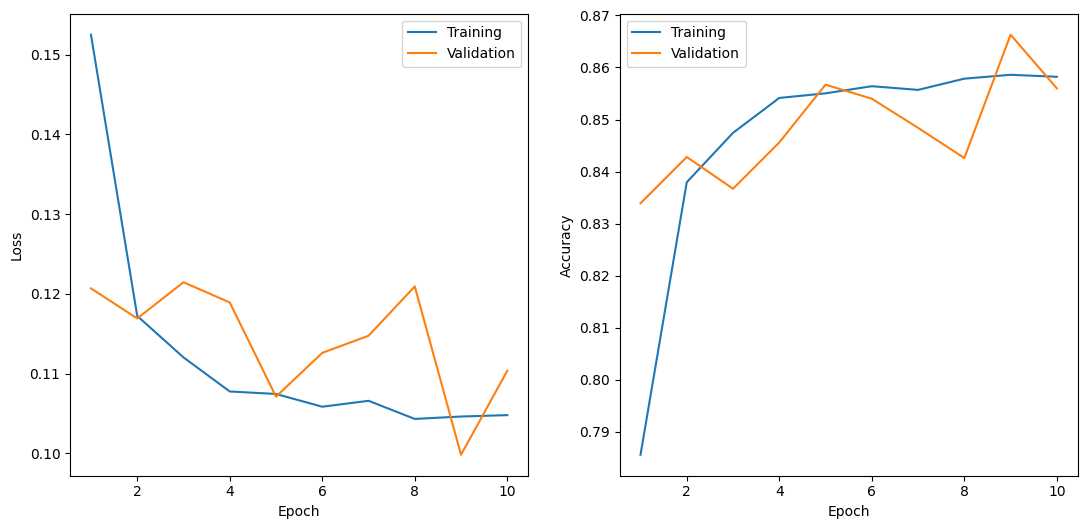

In [38]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.plot(history['epoch'], history['train_loss'], label='Training')
plt.plot(history['epoch'], history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history['epoch'], history['train_score'], label='Training')
plt.plot(history['epoch'], history['val_score'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()